# Feldman Cousins Confidence Intervals

This is a notebook used to evaluate Feldman-Cousins confidence intervals for a given probability distribution. This approach solves the flip-flop problem associated with measurements - if the result of the measurement is consistent with the null hypothesis, a 1-sided confidence interval is often provided, whereas if the measurement is inconsistent with the null hypothesis, a 2-sided confidence interval is often provided. This confidence interval approach is described in this paper:

>Feldman, Gary J., and Robert D. Cousins. "Unified approach to the classical statistical analysis of small signals." Physical Review D 57.7 (1998): 3873.

In [160]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)
sns.set_style('white')
import scipy.stats as stats

import functools
import inspect
from __future__ import division
import sys
sys.path.insert(0, './code')

from statfunctions import KernelEstimator1D

In [2]:
def folded_normal(meas, true):
    return ((1 / np.sqrt(2 * np.pi)) * (
            np.exp(-(meas - true)**2/2.0) +
            np.exp(-(meas + true)**2/2.0))) * (true >= 0)
def bounded_normal(meas, true):
    return (meas >= 0) * np.exp(-(meas - true)**2/2.0)

In [200]:
quad(lambda x, y: bounded_normal(y, x),
     0, np.inf, args=(2,))

(2.449602150638109, 9.778802963858101e-09)

In [398]:
ps, x, up, lo = feldman_cousins_ci(folded_normal,
                                           [0, 10],
                                           [0, 10],
                                           1000,
                                           1000,
                                           ps = [.68, .90])

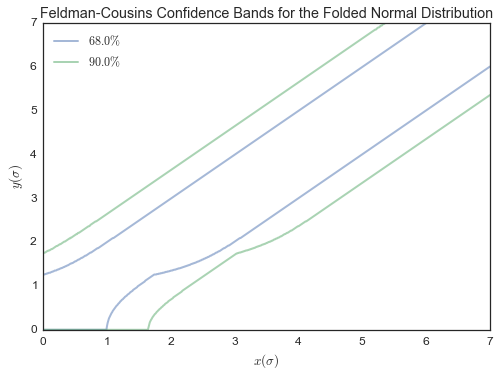

In [399]:
for k, p in enumerate(ps):
    plt.plot(x, up[p], color=colors[k%len(colors)], alpha=alpha, linewidth=linewidth)
    plt.plot(x, lo[p], color=colors[k%len(colors)], alpha=alpha, linewidth=linewidth,label='$'+str(100*p) + '\%$')

xlim = [0, 7]
ylim = [0, 7]
plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('$x(\sigma)$')
plt.ylabel('$y(\sigma)$')
plt.title('Feldman-Cousins Confidence Bands for the Folded Normal Distribution')
_=plt.legend(loc='upper left')

In [3]:
def symmetric_likelihood_ci(function, xlim, ylim, Nx, Ny,
                       ps = [.68, .80, .90, .95, .99, .997],
                       inclusion_contour=False):

    x_reduced = np.linspace(xlim[0], xlim[1], Nx)
    y_reduced = np.linspace(ylim[0], ylim[1], Ny)

    x_2d = np.repeat(np.expand_dims(x_reduced, 1), Ny, axis=1)
    y_2d = np.repeat(np.expand_dims(y_reduced, 1), Nx, axis=1).T

    z_2d = function(x_2d, y_2d)
    z_2d = z_2d / np.sum(z_2d, axis=0, keepdims=True)

    R = (z_2d/np.max(z_2d, axis=0, keepdims=True))

    uppers = {}
    lowers = {}

    for k, p in enumerate(ps):
        integral = np.zeros(Ny)
        inclusion = np.zeros((Nx,Ny))
        upper = []
        lower = []
        for j in range(Ny):
            inds = list(np.flipud(np.argsort(R[:,j])))
            while integral[j] < p:
                if len(inds) == 0:
                    print(integral[j])
                    raise RuntimeError('inds have been depleted and target probability has not been reached.')
                ind = inds.pop(0)
                integral[j] += z_2d[ind, j] #* dy
                inclusion[ind, j] = 1

        for i in range(Nx):
            boundaries = np.abs(inclusion[i, :-1] - inclusion[i, 1:])
            b_inds = [j for j in range(len(boundaries)) if boundaries[j] > 0]
            if len(b_inds) == 0:
                upper.append(np.nan)
                lower.append(np.nan)
            else:
                upper.append(y_reduced[b_inds[-1]])
                if len(b_inds) == 1:
                    lower.append(0)
                else:
                    lower.append(y_reduced[b_inds[0]])
        
        
        lowers[p] = lower
        uppers[p] = upper
        #plt.contour(x_2d, y_2d, inclusion)
    return ps, x_reduced, lowers, uppers

In [4]:
xlim = [0, 10]
ylim = [0, 10]

N = 1000
M = 1000
#dy = (ylim[1] - ylim[0])/float(M)

x_reduced = np.linspace(xlim[0], xlim[1], N)
y_reduced = np.linspace(ylim[0], ylim[1], M)

x_2d = np.repeat(np.expand_dims(x_reduced, 1), M, axis=1)
y_2d = np.repeat(np.expand_dims(y_reduced, 1), N, axis=1).T

z_2d = folded_normal(x_2d, y_2d)
z_2d = z_2d/np.sum(z_2d, axis=0, keepdims=True)

R  = (z_2d/np.max(z_2d, axis=1, keepdims=True))

ps = [.50, .68, .80, .90, .95, .99, .997]
uppers = {}
lowers = {}

for k, p in enumerate(ps):
    integral = np.zeros(M)
    inclusion = np.zeros((N,M))
    upper = []
    lower = []
    for j in range(M):
        inds = list(np.flipud(np.argsort(R[:,j])))
        while integral[j] < p:
            if len(inds) == 0:
                print(integral[j])
                raise RuntimeError('inds have been depleted and target probability has not been reached.')
            ind = inds.pop(0)
            integral[j] += z_2d[ind, j]# * dy
            inclusion[ind, j] = 1
            
    for i in range(N):
        boundaries = np.abs(inclusion[i, :-1] - inclusion[i, 1:])
        b_inds = [j for j in range(len(boundaries)) if boundaries[j] > 0]
        if len(b_inds) == 0:
            upper.append(np.nan)
            lower.append(np.nan)
        else:
            upper.append(y_reduced[b_inds[-1]])
            if len(b_inds) == 1:
                lower.append(0)
            else:
                lower.append(y_reduced[b_inds[0]])
        
        
    lowers[p] = lower
    uppers[p] = upper
    
ps, x, symup, symdo = symmetric_likelihood_ci(folded_normal,
                                               [0, 10],
                                               [0, 10],
                                               1000,
                                               1000,
                                               ps = ps)

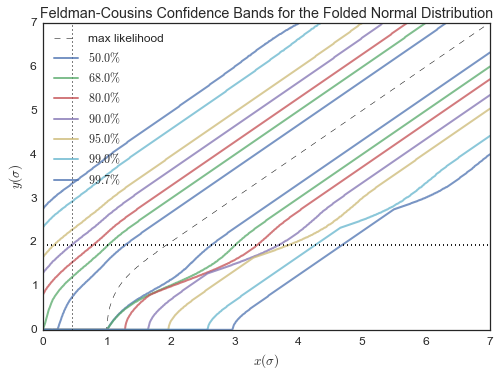

In [5]:
result = 2.6/np.sqrt(4.8**2 + 3.2**2)

#mle0 = y_reduced[np.argmax(z_2d, axis=0)]
mle1 = x_reduced[np.argmax(z_2d, axis=1)]
#med  = x_reduced[np.argmin(np.abs(np.cumsum(z_2d, axis=0) - .5),axis=1)]

up   = KernelEstimator1D(x_reduced, np.array(uppers[.9]))
lo   = KernelEstimator1D(x_reduced, np.array(lowers[.9]))
bands = [up.evaluate_model([result])[0],
         lo.evaluate_model([result])[0]]

colors = sns.color_palette(n_colors=len(ps))
alpha=.75
linewidth = 2

#plt.plot(x_reduced, med, ':k', linewidth=.5, label='median')
plt.plot(x_reduced, mle1, '--k', linewidth=.5, label="max likelihood")

for k, p in enumerate(ps):
    plt.plot(x_reduced, uppers[p], color=colors[k%len(colors)], alpha=alpha, linewidth=linewidth)
    plt.plot(x_reduced, lowers[p], color=colors[k%len(colors)], alpha=alpha, linewidth=linewidth,label='$'+str(100*p) + '\%$')

lims = [0, 7]
plt.xlim(lims)
plt.ylim(lims)

plt.plot([result, result], lims, ':k', linewidth=1.0)
plt.plot(lims, bands[0] * np.ones(2), ':k')
#plt.plot(lims, bands[1] * np.ones(2), ':k')

plt.xlabel('$x(\sigma)$')
plt.ylabel('$y(\sigma)$')
plt.title('Feldman-Cousins Confidence Bands for the Folded Normal Distribution')
_=plt.legend(loc='upper left')
plt.savefig('feldman_cousins_confidence_bands.pdf')

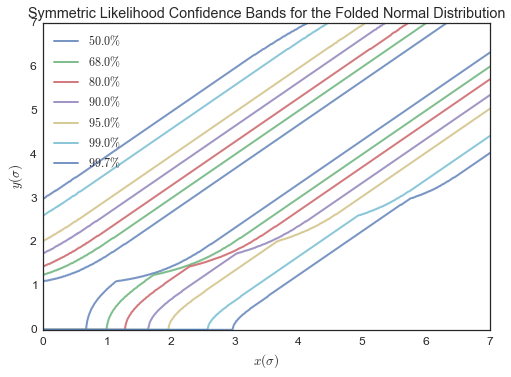

In [6]:
for k, p in enumerate(ps):
    plt.plot(x_reduced, symup[p], color=colors[k%len(colors)], alpha=alpha, linewidth=linewidth)
    plt.plot(x_reduced, symdo[p], color=colors[k%len(colors)], alpha=alpha, linewidth=linewidth,label='$'+str(100*p) + '\%$')
    
lims = [0, 7]
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel('$x(\sigma)$')
plt.ylabel('$y(\sigma)$')
plt.title('Symmetric Likelihood Confidence Bands for the Folded Normal Distribution')
_=plt.legend(loc='upper left')
plt.savefig('symmetric_likelihood_confidence_bands.pdf')

Check that this confidence interval behaves as expected. If I perform the measurement many times, the result falls in this range with the right probability

In [312]:
result = 2.6/np.sqrt(4.8**2 + 3.2**2)
N = 100000
x = np.abs(np.random.normal(size=(N,)) + result)
np.sum(np.logical_and(x < up.evaluate_model([result])[0],
                      x > lo.evaluate_model([result])[0]))/N

0.92269999999999996

Elizabeth defines confidence intervals differently:
If I perform the measurement many times and construct confidence intervals, the confidence intervals will contain the true value 90% of the time.

In [313]:
result = 2.6/np.sqrt(4.8**2 + 3.2**2)
N = 10000
x = np.abs(np.random.normal(size=(N,)) + result)
np.sum(np.logical_and(result < up.evaluate_model(x)[0],
                      result > lo.evaluate_model(x)[0]))/N

0.89610000000000001

Here is the folded normal upper limit, calculated in the same way as the Feldman-Cousins

In [330]:
result = 2.6/np.sqrt(4.8**2 + 3.2**2)
N = 10000
x = np.abs(np.random.normal(size=(N,)) + result)
np.sum(result < up2.evaluate_model(x)[0])/N

0.90149999999999997

Here is the folded normal limit calculated the Bayesian way:

In [19]:
%time np.random.normal(size=(100000,))

Wall time: 5 ms


array([-0.3147153 ,  1.19620789, -1.0991634 , ...,  1.05517648,
       -0.80769458, -0.23345327])

In [28]:
xlim = [0, 10]
ylim = [0, 10]

N = 4000
M = 4000
#dy = (ylim[1] - ylim[0])/float(M)

x_reduced = np.linspace(xlim[0], xlim[1], N)
y_reduced = np.linspace(ylim[0], ylim[1], M)

x_2d = np.repeat(np.expand_dims(x_reduced, 1), M, axis=1)
y_2d = np.repeat(np.expand_dims(y_reduced, 1), N, axis=1).T

z_2d = folded_normal(x_2d, y_2d)
z_2d = z_2d/np.sum(z_2d, axis=1, keepdims=True)
cumul = np.cumsum(z_2d, axis=1)
inds  = np.argmin(np.abs(cumul -p), axis=1)
limit1 = y_reduced[inds]

up3 = KernelEstimator1D(x_reduced, limit1)

In [31]:
mu = np.linspace(1.6, 3.5, 40)
coverage = [compute_coverage(m_i, N=10000) for m_i in mu]

KeyboardInterrupt: 

In [49]:
from scipy.optimize import minimize
from scipy.special import erf
from scipy.integrate import quad

In [83]:
def fnormupper(mu, x, p):
    return ((erf((x + mu)/np.sqrt(2))
            -erf((x - mu)/np.sqrt(2)))/2.0 - p)**2

In [86]:
def bound(x, p=.9):
    return minimize(fnormupper, x, args=(x, p)).x

def normal(x, mu):
    return np.exp(-(x - mu)**2/2.0) * np.sqrt(1 /( 2 * np.pi))

def include(x, mu, p=.9):
    return normal(x, mu) * (mu <= bound(x, p=p))

def coverage(mu, p=.9):
    return quad(include, -np.inf, np.inf, args=(mu,p))

In [91]:
mu = np.linspace(0,5,100)
c = [coverage(m)[0] for m in mu]

(0, 5)

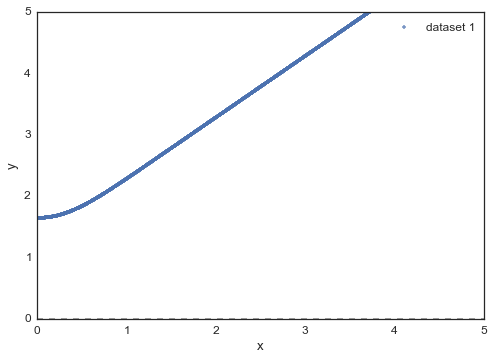

In [35]:
up3.plot()
plt.xlim([0,5])
plt.ylim([0,5])

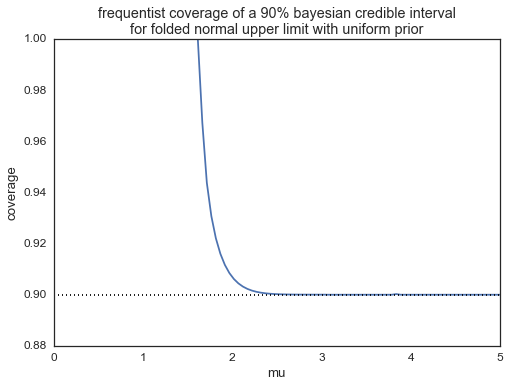

In [93]:
#c, dc = zip(*coverage)
plt.plot(mu, c)
plt.xlabel('mu')
plt.ylabel('coverage')
plt.title('frequentist coverage of a 90% bayesian credible interval\nfor folded normal upper limit with uniform prior')
xlim = plt.gca().get_xlim()
plt.plot(xlim, [.9, .9], ':k')
plt.savefig('frequentist_coverage_of_folded_normal_upper_cred_int_from_integral.pdf')

In [23]:
def compute_coverage(mu, N=10000, rand=None):
    if rand is None:
        x = np.abs(np.random.normal(size=(N,)) + mu)
    else:
        x = rand
        N = len(rand)
    array = mu < up3.evaluate_model(x)[0]
    y = np.mean(array)
    dy= np.std(array)/np.sqrt(N)
    return y, dy

In [338]:
result = 2.6/np.sqrt(4.8**2 + 3.2**2)
N = 10000
x = np.abs(np.random.normal(size=(N,)) + result)
np.sum(result < up3.evaluate_model(x)[0])/N

1.0

Here is the symmetric likelihood confidence interval

In [422]:
result = 2#2.6/np.sqrt(4.8**2 + 3.2**2)
N = 10000
x = np.abs(np.random.normal(size=(N,)) + result)
np.sum(np.logical_and(result < symdoK.evaluate_model(x)[0],
                      result > symupK.evaluate_model(x)[0]))/N

0.89539999999999997

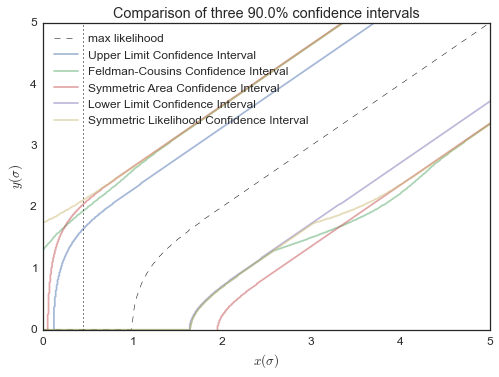

In [9]:
p = .90
lims = [0, 5]

z_2d = folded_normal(x_2d, y_2d)
z_2d = z_2d/np.sum(z_2d, axis=0, keepdims=True)
cumul = np.cumsum(z_2d, axis=0)
inds  = np.argmin(np.abs(cumul - (1-p)), axis=0)
limit = x_reduced[inds]

up2 = KernelEstimator1D(limit, y_reduced)

z_2d = folded_normal(x_2d, y_2d)
z_2d = z_2d/np.sum(z_2d, axis=1, keepdims=True)
cumul = np.cumsum(z_2d, axis=1)
inds  = np.argmin(np.abs(cumul -p), axis=1)
limit1 = y_reduced[inds]

up3 = KernelEstimator1D(x_reduced, limit1)

z_2d = folded_normal(x_2d, y_2d)
z_2d = z_2d/np.sum(z_2d, axis=0, keepdims=True)
cumul = np.cumsum(z_2d, axis=0)
lowinds  = np.argmin(np.abs(cumul - ((1-p)/2.0)), axis=0)
highinds = np.argmin(np.abs(cumul - (1 - (1 - p)/2.0)), axis=0)
symlow  = x_reduced[lowinds]
symhigh = x_reduced[highinds] 

z_2d = folded_normal(x_2d, y_2d)
z_2d = z_2d/np.sum(z_2d, axis=1, keepdims=True)
cumul = np.cumsum(z_2d, axis=1)
inds  = np.argmin(np.abs(cumul - p), axis=1)
limit2 = y_reduced[inds]

central_limit = [x_reduced + erfinv(p)*np.sqrt(2),
                 x_reduced - erfinv(p)*np.sqrt(2)]

symupK = KernelEstimator1D(x_reduced, np.array(symup[p]))
symdoK = KernelEstimator1D(x_reduced, np.array(symdo[p]))

plt.plot(x_reduced, mle1, '--k', linewidth=.5, label="max likelihood")

alpha=.5
plt.plot(limit, y_reduced, color=colors[0], alpha=alpha, label='Upper Limit Confidence Interval')
#plt.plot(x_reduced, limit1, color=colors[5], alpha=alpha, label='Upper Limit Bayesian')
plt.plot(x_reduced, uppers[p], color=colors[1], alpha=alpha, label='Feldman-Cousins Confidence Interval')
plt.plot(x_reduced, lowers[p], color=colors[1], alpha=alpha)
#plt.plot(x_reduced, central_limit[0], color=colors[2], alpha=alpha, label='Normal Central Confidence Interval')
#plt.plot(x_reduced, central_limit[1], color=colors[2], alpha=alpha)
plt.plot(symlow,  y_reduced, color = colors[2], alpha=alpha, label='Symmetric Area Confidence Interval')
plt.plot(symhigh, y_reduced, color = colors[2], alpha=alpha)
plt.plot(limit2, y_reduced, color=colors[3], alpha=alpha, label='Lower Limit Confidence Interval')
plt.plot(x_reduced, symdo[p], color = colors[4], alpha=alpha, label='Symmetric Likelihood Confidence Interval')
plt.plot(x_reduced, symup[p], color = colors[4], alpha=alpha)

plt.plot([result, result], lims, ':k', linewidth=1.0)

plt.xlim(lims)
plt.ylim(lims)

plt.title('Comparison of three ' + str(100 * p) + '% confidence intervals')
plt.xlabel('$x(\sigma)$')
plt.ylabel('$y(\sigma)$')
plt.legend(loc='upper left')
plt.savefig('90_percent_confidence_interval_comparison.pdf')

In [81]:
class ProbDist(object):
    def __init__(self, function, bounds=None, discrete=False):
        self.function = function
        if bounds is None:
            arg_num = len(inspect.getargspec(find_maximum).args)
            bounds = [(-np.inf, np.inf)] * arg_num
        self.bounds   = bounds
        self.discrete = False
        
    def rotate_variables(self, args=(None,)):
        
        
    def feldman_cousins_ci(self, p=.90, args=(None,)):
        """
        Get feldman cousins confidence interval with other
        arguments fixed. Unfixed argument specied by an input None
        """
        ind = args.index(None)
        args = list(args)
        args.pop(ind)
        
        def modified(*args):
            args = list(args)
            special_arg = args.pop(0)
            args.insert(ind, special_arg)
            print args
            return
        return modified
    
        

In [ ]:
stats.foldnorm.

In [51]:
stats.foldnorm

In [53]:
class ConfidenceIntervals(object):
    def __init__(distribution, dx=.01, x_bounds=None ,*args, **kwargs):
        """
        inputs:
        distribution (scipy.stats.distn object)
        *args    arguments for the distribution object
        **kwargs arguments for the distribution object
        """
        self.distribution = distribution(*args, **kwargs)
        self.args   = args
        self.kwargs = kwargs
        
    def ci_by_ordering_principle(self, ordering, p=.90):
        pass
    
    def symmetric_likelihood_ci(self, p=.90):
        pass
        
    def feldman_cousins_ci(self, p=.90):
        pass
    
    def symmetric_area_ci(self, p=.90):
        pass
    
    def upper_limit(self, p=.90):
        pass
    
    def lower_limit(self, p=.90):
        pass

In [47]:
a = stats.foldnorm(2)

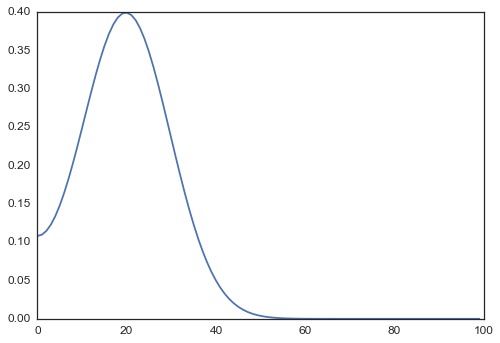

In [49]:
b = a.pdf(np.linspace(0,10,100))
plt.plot(b)

In [73]:
def find_maximum(function, start_point=0, args=None, bounds=None, **kwargs):
    out = minimize(lambda *args: -np.log(function(*args)),
                   start_point, args=args, bounds=[bounds])
    if not(out.success):
        print('problem with optimization')
    return out.x

def find_equal_likelihood_bounds(function, likelihood=.10, maximum=None, shift=.1,
                                 start_point=0, args=None, bounds=None, **kwargs):
    if maximum is None:
        maximum = find_maximum(function, start_point=start_point, 
                               args=args, bounds=bounds, **kwargs)
    P0 = function(maximum, *args)
    starts = np.array([maximum - shift, maximum + shift])
    if bounds is not None:
        starts[starts < bounds[0]] = bounds[0]
        starts[starts > bounds[1]] = bounds[1]
        
    find_crossing = lambda i : (
        minimize(lambda *argz: np.abs(np.log(function(*argz)/(P0 * likelihood))),
                 starts[i], args=args, bounds=[bounds], **kwargs)
    )
        
    out0 = find_crossing(0)
    out1 = find_crossing(1)
    #if not(out0.success and out1.success):
    #    print('problem with optimization')
    return np.squeeze(np.array([out0.x, out1.x])), maximum
    
true = 3
a, b = find_equal_likelihood_bounds(folded_normal, start_point=1, args=(3,), bounds=(0, np.inf), likelihood=.0001)
b = folded_normal(a, true)/ folded_normal(b, true)
print(b)
print(a)

[ 0.02221799  0.0001    ]
[ 0.          7.29193205]


In [600]:
def calculate_confidence_intervals(function, p=.90, tolerance=1E-6, shift=.1,
                                   start_point=1, args=None, bounds=None, **kwargs):
    integral   = np.array(0.0, dtype=np.int64)
    maximum    = None    # starting point for the known maximum
    likelihood = .70     # starting point for likelihood
    likelihood_step = .1 # starting point for likelihood step
    previous_lims = None
    modification = 1.5
    max_N = 2000
    min_shift = .1
    i = 0
    while True:
        if shift < min_shift:
            shift = min_shift
        lims, maximum = find_equal_likelihood_bounds(function, likelihood=likelihood, maximum=maximum, shift=shift,
                                                       start_point=start_point, args=args, bounds=bounds, **kwargs)
        #print(likelihood, integral, lims)
        
        shift = np.mean(np.abs(lims - maximum))
        lims = list(lims)
        maximum = float(maximum)
        
        if previous_lims is None:
            integration_limits = [(lims[0], maximum),
                                  (maximum, lims[1])]
        else:
            integration_limits = [(lims[0], previous_lims[0]),
                                  (previous_lims[1], lims[1])]
            
        #curr_int = 0
        #for limits in integration_limits:
        #    curr_int += quad(function, limits[0], limits[1], args=args)[0]
        #new_int = integral + curr_int
        new_int = quad(function, lims[0], lims[1], args=args)[0]
        
        if np.abs(new_int - p) < tolerance:
            return lims
        elif new_int <= p:
            integral = new_int
            previous_lims = lims
            direction = -1
        else:
            direction = +1
            likelihood_step /= modification
        likelihood, likelihood_step = adjust_likelihood(likelihood, 
                                                        likelihood_step, 
                                                        direction,
                                                        modification=modification)
            
        i += 1
        if i > max_N:
            return [np.nan, np.nan]
        
def adjust_likelihood(likelihood, likelihood_step, direction, modification=2.0):
    step = lambda x: np.sign(direction) * np.abs(x)
    while True:
        new_likelihood = likelihood + step(likelihood_step)
        if (new_likelihood < 1) and (new_likelihood > 0):
            return new_likelihood, likelihood_step
        else:
            likelihood_step /= modification

In [621]:
ps = [.68, .80, .90, .95, .99, .997]
uppers = []
lowers = []
for p in ps:
    print('p=' + str(p))
    ys = np.linspace(0, 5, 40)
    upper = []
    lower = []
    for y in ys:
        lims = calculate_confidence_intervals(folded_normal, p=p, tolerance=1E-4, shift=.1,
                                              start_point=y + .254, args=(y,), bounds=(0, np.inf))
        lower.append(lims[0])
        upper.append(lims[1])
    uppers.append(upper)
    lowers.append(lower)

p=0.68
p=0.8
p=0.9
p=0.95
p=0.99
p=0.997


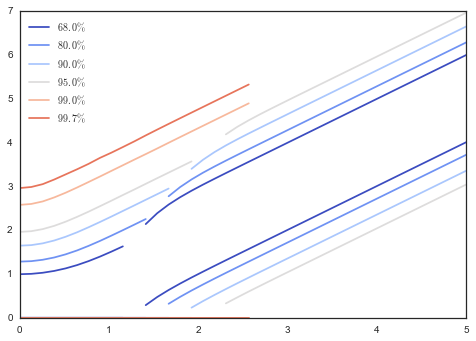

In [622]:
colors = cm.coolwarm
for i, (p, lower, upper) in enumerate(zip(ps, lowers, uppers)):
    plt.plot(ys, lower, color=colors(i/len(ps)), label='$' + str(p*100) + '\%$')
    plt.plot(ys, upper, color=colors(i/len(ps)))
plt.legend(loc='best')

In [345]:
from scipy.stats import foldnorm

In [350]:
foldnorm?

In [368]:
p = .90
x = np.linspace(0,6,50)
low, high = foldnorm.interval(.9,x)

In [372]:
result = 2.6/np.sqrt(4.8**2 + 3.2**2)
N = 10000
x = np.abs(np.random.normal(size=(N,)) + result)
low, high = foldnorm.interval(.90, x)
np.sum(np.logical_and(result < high,
                      result > low))/N

0.93730000000000002

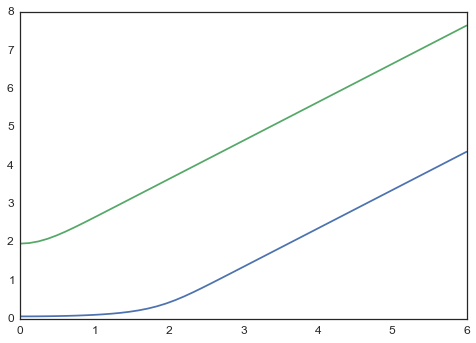

In [370]:
plt.plot(x, low)
plt.plot(x, high)

In [380]:
foldnorm.interval?

In [183]:
def jeffries_prior(mu):
    integrand = lambda x, m: (
        (1 - (x/np.cosh(x * m))**2) * 
        (np.exp(-(x + m)**2/2.0) + np.exp(-(x - m)**2/2.0))
    )
    integral = quad(integrand, -np.inf, np.inf, args=(mu,))[0]
    return np.sqrt(np.abs(integral))

def foldnorm_posterior(x, x_min, x_max, N):
    mu = np.linspace(x_min, x_max, N)
    prior = np.array([jeffries_prior(m) for m in mu])
    data  = np.array([folded_normal(x, m) for m in mu])
    posterior = data * prior
    posterior = posterior/np.sum(posterior)
    return mu, posterior

def max_entropy_dist():
    pass

In [184]:
mu = np.linspace(0, 5, 100)
L  = np.array([jeffries_prior(m) for m in mu])

In [187]:
x = .75
mu, post = foldnorm_posterior(x,.001, 10, 500)
pre = folded_normal(x, mu)
pre = pre/np.sum(pre)
log = pre / mu
log = log/np.sum(log)

here are some posterior distributions that depend on different priors:
- Jeffrey's (uninformative prior)
- Flat Prior in $\mu$ (believe the EDM is on this order of magnitude)
- Flat Prior in $\log{\mu}$ (believe the EDM is fairly uniformly distributed on the log scale (kind of like the beyond the standard model theories)

(0, 0.05)

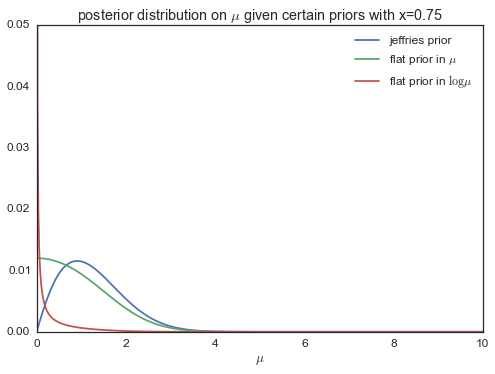

In [188]:
plt.plot(mu, post, label='jeffries prior')
plt.plot(mu, pre,  label='flat prior in $\mu$')
plt.plot(mu, log,  label='flat prior in $\log{\mu}$')
plt.legend(loc='best')
plt.xlabel('$\mu$')
plt.title('posterior distribution on $\mu$ given certain priors with x=' + str(x))
plt.ylim([0,.05])

The log prior results in a posterior that is not integrable unless I cut off the distribution (which presumably I would end at around the standard model $10^{-38} e\cdot cm$ level, which here would be roughly $\mu\sim 10^{-9}$ and start around the YbF level near $\mu\sim 10$, which spans 10 order of magnitude and hence is likely to favor something around $\mu\sim 10^{-4}$ given a nullish result

In [ ]:
# can I compare bayesian confidence intervals with different priors, 
# and compare their frequentist coverage properties?

In [14]:
from statfunctions import correlation_coefficient

In [21]:
N = 10680
x = np.random.normal(size=(N,))
y = np.random.normal(size=(N,))

r = correlation_coefficient(x, y)

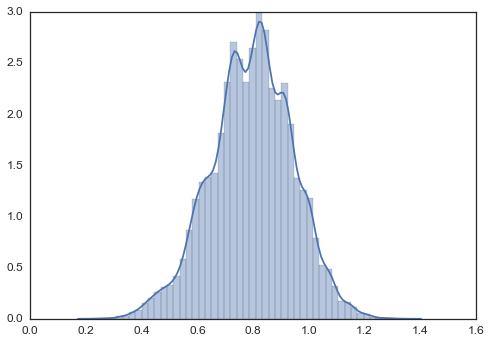

In [181]:
def bootstrap(function, samples, N=50000):
    inds = np.random.randint(len(samples), size=(N, len(samples)))
    return [function(samples[i]) for i in inds]

resampled = bootstrap(lambda x: np.std(x),
                      np.random.normal(size=(15,)),
                      N=100000)

sns.distplot(resampled)